In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

In [2]:
# open dataset
year = "2018"
hubv = xarray.open_dataset("hubbard_%s.nc" % year)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:08<00:00, 15.64it/s]


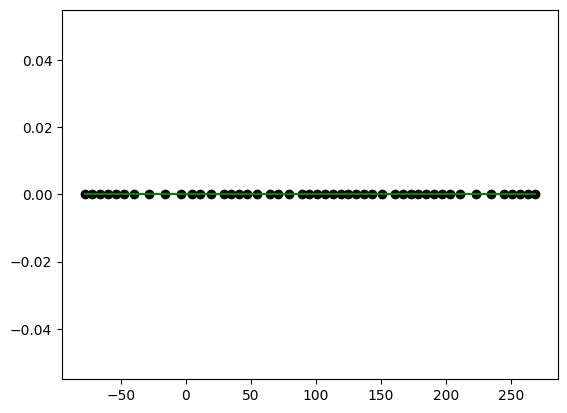

In [3]:
# t0 = np.datetime64("%s-09-01" % (str(int(year)-1)))
# t1 = np.datetime64("%s-10-01" % year)
# mask = np.logical_and(hubv.time > t0, hubv.time < t1)
import warnings
ns_in_day = 60*60*24*1e9
epoch = np.datetime64("%s-01-01" % year)
t = ((hubv.time[:]-epoch).to_numpy()/ns_in_day).astype(np.float32)

amp0 = np.zeros((hubv.speed.shape[1], hubv.speed.shape[2]))
amp1 = np.zeros((hubv.speed.shape[1], hubv.speed.shape[2]))
phase0 = np.zeros((hubv.speed.shape[1], hubv.speed.shape[2]))
phase1 = np.zeros((hubv.speed.shape[1], hubv.speed.shape[2]))

amp0[:] = np.nan
amp1[:] = np.nan
phase0[:] = np.nan
phase1[:] = np.nan


# Fit smooth function to data and identify peaks
for i in tqdm(range(hubv.speed.shape[1])):
    for j in range(hubv.speed.shape[2]):
        v = hubv.speed[:,i,j]
        ti = np.linspace(np.min(t), np.max(t), 1000)

        # Cubic spline
        #cs = scipy.interpolate.CubicSpline(t, v)
        #vi = cs(tp)
        
        # Suppress all rank warnings
        warnings.filterwarnings('ignore', category=np.RankWarning)

        # Polynomial fit
        m = np.polyfit(t, v, 12)
        vi = np.polyval(m, ti)

        ##### this looks for mimima instead of maxima
        #vi = -vi 
        pk = scipy.signal.find_peaks(vi, prominence=50)[0]
        #vi = -vi 
        ######
        
        if(len(pk) == 1):
            amp0[i,j] = vi[pk[0]]
            phase0[i,j] = ti[pk[0]]
            continue
        elif(len(pk) == 2):
            amp0[i,j] = vi[pk[0]]
            phase0[i,j] = ti[pk[0]]
            amp1[i,j] = vi[pk[1]]
            phase1[i,j] = ti[pk[1]]
            continue


plt.plot(t, v, "ko-")
plt.plot(ti, vi, "g-")
plt.plot(ti[pk], vi[pk], "ro")

In [75]:
import rasterio as rio
import affine

ds = xarray.load_dataset("hubbard_%s.nc" % year)

res = ds.x[1]-ds.x[0]

xform = affine.Affine.translation(ds.x[0] - res / 2, ds.y[0] - res / 2) * affine.Affine.scale(res, -res)

#v = np.sqrt(ds.vx**2 + ds.vy**2)
#vmean = np.mean(v, axis=0)

with rio.open(
    "./amp1.tif",
    "w",
    driver='GTiff',
    height=amp1.shape[0],
    width=amp1.shape[1],
    count=1,
    dtype=amp1.dtype,
    crs="EPSG:3413",
    transform=xform,
) as ds_out:
    ds_out.write(amp1, 1)

In [5]:
# # Mask for areas without double peak
# mask = np.logical_and(np.logical_not(np.isnan(amp0)), np.logical_not(np.isnan(amp1))).reshape(amp0.shape)
# amp0[np.logical_not(mask)] = np.nan
# amp1[np.logical_not(mask)] = np.nan
# phase0[np.logical_not(mask)] = np.nan
# phase1[np.logical_not(mask)] = np.nan

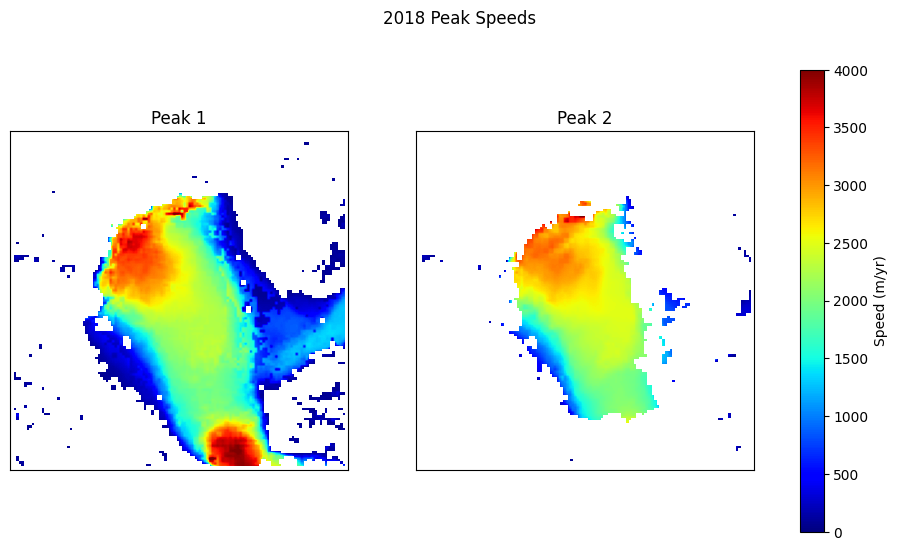

In [7]:
import matplotlib.pyplot as plt

# Adjust the figure size by specifying figsize=(width, height)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Increase width and height as needed

# Plot for the first subplot
im = axs[0].imshow(amp0, vmin=0, vmax=4000, cmap="jet")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Peak 1")

# Plot for the second subplot
im1 = axs[1].imshow(amp1, vmin=0, vmax=4000, cmap="jet")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Peak 2")

# Set the title of the entire figure
fig.suptitle("%s Peak Speeds" % year)

# Add colorbars to the subplots
fig.colorbar(im, ax=axs, label="Speed (m/yr)")

# Save the figure
plt.savefig("%s_Hubbard_Peak_Amplitude.pdf" % year, bbox_inches="tight")


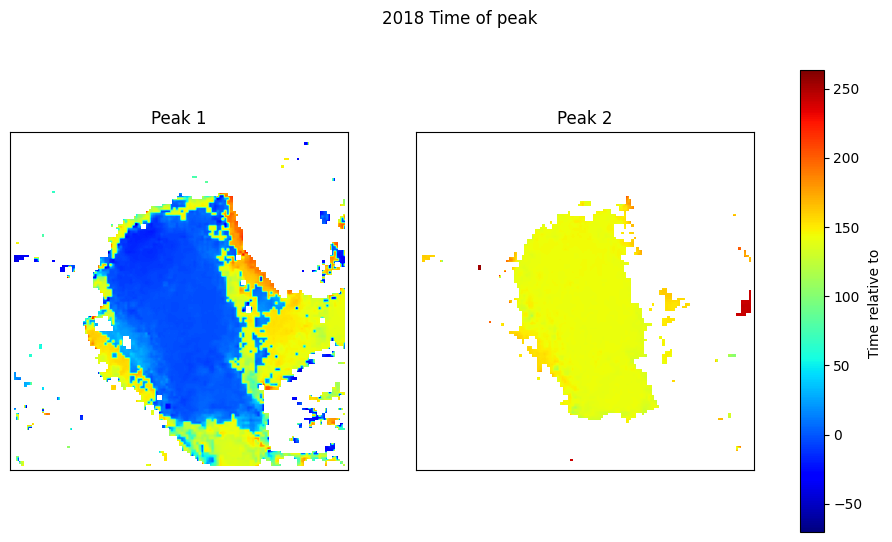

In [8]:
import matplotlib.pyplot as plt

# Adjust the figure size by specifying figsize=(width, height)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Increase width and height as needed

# Plot for the first subplot
im = axs[0].imshow(phase0, vmin=np.nanmin(phase0), vmax=np.nanmax(phase1), cmap="jet")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Peak 1")

# Plot for the second subplot
im1 = axs[1].imshow(phase1, vmin=np.nanmin(phase0), vmax=np.nanmax(phase1), cmap="jet")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Peak 2")

# Set the title of the entire figure
fig.suptitle("%s Time of peak" % year)

# Add colorbars to the subplots
fig.colorbar(im, ax=axs, label="Time relative to ")

# Save the figure
plt.savefig("%s_Hubbard_Peak_Amplitude.pdf" % year, bbox_inches="tight")


In [4]:
# get extent of double peak plot

# Given center coordinate
center_x = -3310000
center_y = 257700

# Offset for moving northward (in meters)
offset = 8000

xmin = center_x - offset
xmax = center_x + offset
ymin = center_y - offset
ymax = center_y + offset

#print(xmin, xmax, ymin, ymax)

In [14]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import elevation
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import rasterio


def calculate_slope_angle(dem, cell_size):
    """
    Calculate slope angle from a Digital Elevation Model (DEM).
    
    Parameters:
        dem (numpy.ndarray): 2D array representing the DEM.
        cell_size (float): Size of each cell in the DEM (in meters).
        
    Returns:
        numpy.ndarray: 2D array containing the slope angles (in degrees).
    """
    # Calculate gradient using central differences
    dz_dx, dz_dy = np.gradient(dem, cell_size, cell_size)
    
    # Calculate slope angle
    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    slope_deg = np.degrees(slope_rad)
    
    return slope_deg
    
# Open the GeoTIFF file
with rasterio.open('ifsar_hubbardDEM_reproj.tif') as src:
    # Read the raster data
    data = src.read(1)  # Assuming a single band image

    # Get the affine transformation matrix
    transform = src.transform
    left, bottom, right, top = src.bounds

#####
# read file and calculate slope
image = imageio.imread('ifsar_hubbardDEM_reproj.tif')
slope = calculate_slope_angle(image, 5)

# plt.imshow(slope, cmap='viridis', norm=norm)
# plt.colorbar(label='Slope') 
# #plt.ylim([6500, 2000])
# #plt.xlim([3000, 6250])
# plt.axis('off')  # Turn off axis labels
# plt.show()

/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_67713/364549933.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('ifsar_hubbardDEM_reproj.tif')


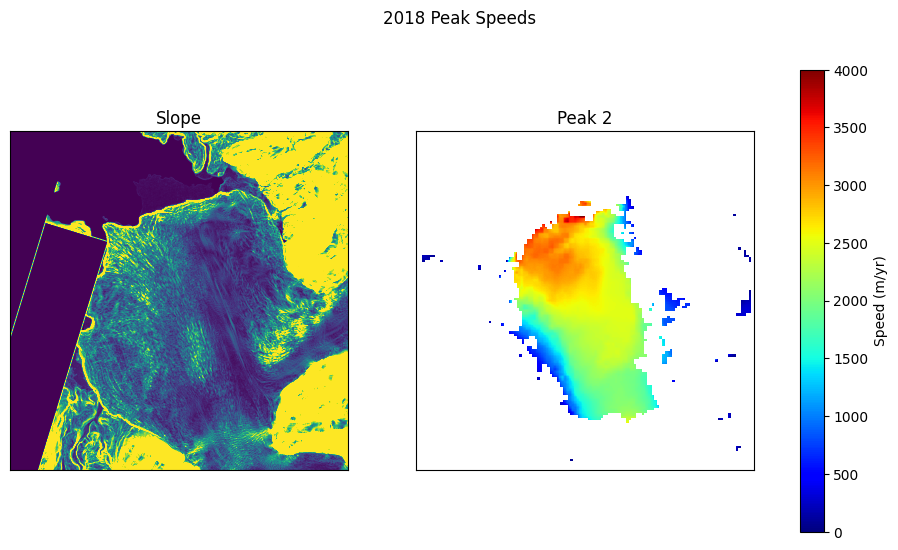

In [15]:
# Adjust the figure size by specifying figsize=(width, height)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Increase width and height as needed

im0 = axs[0].imshow(slope, extent=[left, right, bottom, top], vmin=0, vmax=20, cmap="viridis")
axs[0].set_xlim([xmin, xmax])
axs[0].set_ylim([ymin, ymax])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Slope")
#axs[0].plot(df["map_x"], df["map_y"], color='r')

# # Add colorbars to the subplots
# fig.colorbar(im0, ax=axs, label="Slope (deg)")

# Plot for the second subplot
im1 = axs[1].imshow(amp1, vmin=0, vmax=4000, cmap="jet")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Peak 2")

# Set the title of the entire figure
fig.suptitle("%s Peak Speeds" % year)

# Add colorbars to the subplots
fig.colorbar(im1, ax=axs, label="Speed (m/yr)")

# Save the figure
plt.savefig("%s_Hubbard_Slope_Amplitude.pdf" % year, bbox_inches="tight")


In [16]:
import pandas as pd 
df = pd.read_csv("peak_outline.csv") 
#print(df)
df["map_x"] = df["X"]  # Replace "x_column_name" with the actual name of your x-column
df["map_y"] = df["Y"]  # Replace "y_column_name" with the actual name of your y-column

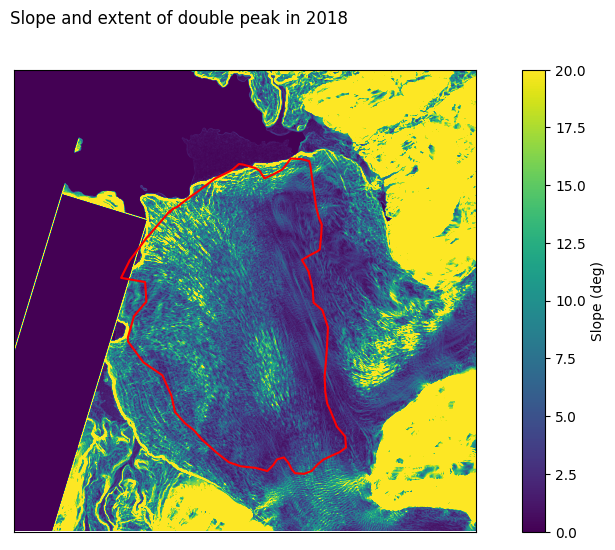

In [17]:
# Adjust the figure size by specifying figsize=(width, height)
fig, axs = plt.subplots(1, 1, figsize=(12, 6))  # Increase width and height as needed

im0 = axs.imshow(slope, extent=[left, right, bottom, top], vmin=0, vmax=20, cmap="viridis")
axs.set_xlim([xmin, xmax])
axs.set_ylim([ymin, ymax])
axs.set_xticks([])
axs.set_yticks([])
axs.plot(df["map_x"], df["map_y"], color='r')

# Set the title of the entire figure
fig.suptitle("Slope and extent of double peak in %s " % year)

# Add colorbars to the subplots
fig.colorbar(im0, ax=axs, label="Slope (deg)")

# Save the figure
plt.savefig("%s_Hubbard_Slope.pdf" % year, bbox_inches="tight")


In [ ]:
from osgeo import gdal, ogr
import os

# Input shapefile and raster file paths
shapefile_path = "ifsar_outline.shp"
raster_file_path = "ifsar_hubbardDEM_reproj.tif"
output_raster_path = "ifsar_hubbardDEM_crop.tif"

# Open the shapefile
shapefile = ogr.Open(shapefile_path)
layer = shapefile.GetLayer()

# Get the geometry from the shapefile
feature = layer.GetNextFeature()
geometry = feature.GetGeometryRef()

# Open the raster file
raster = gdal.Open(raster_file_path)

# Get the extent of the geometry
xmin, xmax, ymin, ymax = geometry.GetEnvelope()

# Define the output raster resolution and geotransform
x_res = raster.GetGeoTransform()[1]
y_res = -raster.GetGeoTransform()[5]
geotransform = (xmin, x_res, 0, ymax, 0, -y_res)

# Create a new raster in memory
mem_driver = gdal.GetDriverByName('MEM')
clipped_raster = mem_driver.Create('', int((xmax-xmin)/x_res), int((ymax-ymin)/y_res), 1, gdal.GDT_Float32)

# Set the geotransform and projection
clipped_raster.SetGeoTransform(geotransform)
clipped_raster.SetProjection(raster.GetProjection())

# Perform the clip
gdal.RasterizeLayer(clipped_raster, [1], layer, burn_values=[1])

# Create output raster file
driver = gdal.GetDriverByName('GTiff')
out_raster = driver.CreateCopy(output_raster_path, clipped_raster)

# Clean up
del shapefile, raster, clipped_raster, out_raster

